# Fashion MNIST using Linear Layers with JAX

- toc: true
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png
- hide: true



In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from typing import Tuple, List, Any, Dict, Callable


2022-07-16 21:52:53.905857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/bin:/usr/local/lib:


## PyTorch / fast.ai like Data API

In [2]:
class Dataset:
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return jnp.shape(self.X)[0]
    def __getitem__(self, i):
        return self.X[i,:], self.y[i]

In [3]:
class Dataloader:
    def __init__(self, dataset: Dataset, batchsize=32, shuffle=False):
        self.dataset = dataset
        self.batchsize = batchsize
        self.shuffle = shuffle
    def __iter__(self):
        for i in range(0, len(self.dataset), self.batchsize): 
            yield self.dataset[i:i+self.batchsize]
        

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

In [5]:
fashion_mnist.load_data??

Signature: fashion_mnist.load_data()
Source:   
@keras_export('keras.datasets.fashion_mnist.load_data')
def load_data():
  """Loads the Fashion-MNIST dataset.

  This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images. This dataset can be used as
  a drop-in replacement for MNIST.

  The classes are:

  | Label | Description |
  |:-----:|-------------|
  |   0   | T-shirt/top |
  |   1   | Trouser     |
  |   2   | Pullover    |
  |   3   | Dress       |
  |   4   | Coat        |
  |   5   | Sandal      |
  |   6   | Shirt       |
  |   7   | Sneaker     |
  |   8   | Bag         |
  |   9   | Ankle boot  |

  Returns:
    Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

  **x_train**: uint8 NumPy array of grayscale image data with shapes
    `(60000, 28, 28)`, containing the training data.

  **y_train**: uint8 NumPy array of labels (integers in range 0-9)
    with shape `(60000,)` for the training data.

  *

In [6]:
dataset = Dataset(X_train, y_train)

In [7]:
dataloader = Dataloader(dataset)

In [8]:
for X, y in dataloader:
    print(X.shape, y.shape)
    

(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28) (32,)
(32, 28, 28)

## Model API

In [9]:
class Module: pass


### Linear Layer

In [10]:
class Linear(Module):
    w: jnp.ndarray 
    b: jnp.ndarray
    ni: int 
    no: int 

    def __init__(self, num_inputs, num_outputs, seed=1234):
        self.ni = num_inputs 
        self.no = num_outputs 
        key = jax.random.PRNGKey(seed)
        self.w = jax.random.normal(key, (num_inputs, num_outputs)) * jnp.sqrt(2.0 / num_inputs)
        self.b = jnp.zeros(num_outputs)
        
    def __call__(self, x):
        return jnp.dot(x, self.w) + self.b
        
    def params(self):
        return {'b': self.b, 'w': self.w}


In [11]:
l = Linear(2, 1)
x = np.random.randn(2)
y = l(x)

print(y)


[1.2276616]


In [12]:
def mse(model, X, y):
    preds = jax.vmap(model)(X)
    return jnp.mean((preds - y)**2)


In [13]:
print(mse(l, x, 2.0))
print(mse(l, np.random.randn(10, 2), np.random.randn(10)))

4.035294
0.523962


In [14]:
mse_grad = jax.grad(mse)
mse_grad(l, x, 2.0)

TypeError: Argument '<__main__.Linear object at 0x7f9b4ac74b50>' of type <class '__main__.Linear'> is not a valid JAX type.

To get this to work, the `Linear` class must be registered as a pytree.  

In [15]:
@jax.tree_util.register_pytree_node_class
class Linear(Module):
    w: jnp.ndarray 
    b: jnp.ndarray
    ni: int 
    no: int 

    def __init__(self, num_inputs, num_outputs, build=True, seed=1234):
        self.ni = num_inputs 
        self.no = num_outputs 
        # want to add seed as internal object
        if build:
            key = jax.random.PRNGKey(seed)
            self.w = jax.random.normal(key, (num_inputs, num_outputs)) * jnp.sqrt(2.0 / num_inputs)
            self.b = jnp.zeros(num_outputs)
    
    def merge(self, params):
        self.w, self.b = params

    def __repr__(self):
        return f'Linear(num_inputs={self.ni}, num_outputs={self.no})'
        
    def __call__(self, x):
        return jnp.dot(x, self.w) + self.b
        
    def params(self):
        return {'b': self.b, 'w': self.w}

    def tree_flatten(self):
        return [self.w, self.b], [self.ni, self.no]

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        layer = cls(*aux_data, build=False)
        layer.merge(params=children)
        return layer

In [16]:
lin = Linear(2, 1)

In [17]:
params, extra_stuff = lin.tree_flatten()

In [18]:
lin2 = Linear.tree_unflatten(extra_stuff, params)

In [19]:
print(lin.w)
print(lin2.w) 

[[ 0.43957582]
 [-0.26563603]]
[[ 0.43957582]
 [-0.26563603]]


In [20]:
@jax.jit
@jax.value_and_grad
def mse(model, X, y):
    preds = jax.vmap(model)(X)
    return jnp.mean((preds - y)**2)

In [21]:
X = np.random.randn(10, 2)
y = np.random.randn(10)

loss, g_loss = mse(lin, X, y)
print(loss, g_loss)

1.7428839 Linear(num_inputs=2, num_outputs=1)


In [22]:
g_loss.__dict__

{'ni': 2,
 'no': 1,
 'w': DeviceArray([[ 1.4666067],
              [-0.3670275]], dtype=float32),
 'b': DeviceArray([-0.55795026], dtype=float32)}

In [23]:
jax.tree_util.tree_flatten(g_loss)

([DeviceArray([[ 1.4666067],
               [-0.3670275]], dtype=float32),
  DeviceArray([-0.55795026], dtype=float32)],
 PyTreeDef(CustomNode(<class '__main__.Linear'>[[2, 1]], [*, *])))

In [24]:
locals()['Linear'].__class__

type

### Helper Functions

In [25]:
def flatten(x: jnp.ndarray): 
    return jnp.reshape(x, -1) 


In [26]:
def relu(x: jnp.ndarray): 
    return jnp.clip(x, a_min=0)

   

In [27]:
x = np.random.randn(10,10)
assert jnp.all(jnp.isclose(relu(x), jax.nn.relu(x))), 'test failed'

In [28]:
def softmax(x: jnp.ndarray):
    ex = jnp.exp(x)
    return ex / jnp.sum(ex)

In [29]:
x = np.random.randn(10)
assert jnp.all(jnp.isclose(softmax(x), jax.nn.softmax(x))), 'test failed'

In [30]:
_registry = {
    flatten.__name__: flatten,
    softmax.__name__: softmax,
    relu.__name__: relu
}

### Sequential Module

In [31]:
@jax.tree_util.register_pytree_node_class
class Sequential(Module):
    layers: List
    def __init__(self, *layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def tree_flatten(self):
        aux_data, children = [], []
        for layer in self.layers:
            if isinstance(layer, Module):
                params, extra_stuff = layer.tree_flatten()
                aux_data.append([layer.__class__.__name__] + extra_stuff)
                children.append(params) 
            elif callable(layer):
                # a layer function that doesn't have any paramerers ...
                aux_data.append(layer.__name__)
                children.append(None)    
        return children, aux_data
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        layers = []
        # Want a more generic way to unflatten
        for params, spec in zip(children, aux_data):
            if isinstance(spec, list):
                layer_name, *args = spec
                if layer_name == 'Linear':
                    layers.append(Linear.tree_unflatten(args, params))   
            elif isinstance(spec, str) and spec in _registry:
                layers.append(_registry[spec])
        return Sequential(*layers)
    

In [57]:

def fashion_mnist_mlp():
    model = Sequential(
        flatten,
        Linear(784, 128),
        relu,
        Linear(128, 10),
        softmax   
    )

    return model 


model = fashion_mnist_mlp()
params, extra_stuff = model.tree_flatten()
print(extra_stuff)
print(params)

['flatten', ['Linear', 784, 128], 'relu', ['Linear', 128, 10], 'softmax']
[None, [DeviceArray([[-0.00503162, -0.11710759,  0.05479915, ..., -0.07662067,
              -0.03762808,  0.037621  ],
             [-0.02311066,  0.00427538,  0.06703123, ...,  0.05820996,
              -0.03371886, -0.0653995 ],
             [-0.03936624,  0.08184296, -0.00103856, ..., -0.02543773,
               0.00404367,  0.10533019],
             ...,
             [-0.05674443,  0.01220774, -0.04277196, ...,  0.00793091,
              -0.03246848,  0.05214054],
             [-0.10229313, -0.04473471, -0.05902693, ..., -0.026743  ,
               0.01399903, -0.02305236],
             [ 0.02624378, -0.040582  ,  0.04346804, ..., -0.0069246 ,
               0.04329436,  0.07048796]], dtype=float32), DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Cross-entropy Loss

In [38]:
@jax.value_and_grad
def cross_entropy(model, X, y, num_cats=10):
    y_one_hot = jax.nn.one_hot(y, num_cats)
    log_softmax = jnp.log(jax.vmap(model)(X))
    return -jnp.mean(log_softmax * y_one_hot)
    

In [39]:

value, grads = cross_entropy(model, np.random.randn(5, 28, 28), [1,0,1,1,0])
print(value)

0.31954172


In [42]:
updated_model = jax.tree_util.tree_map(lambda p, g: p - 1e-3*g, model, grads)

In [43]:
assert jnp.all(jnp.isclose(updated_model.layers[1].w, model.layers[1].w - 1e-3*grads.layers[1].w))

## Stochastic Gradient Descent

In [44]:
class Optimizer: pass 

In [45]:
class SGD(Optimizer):
    def __init__(self, model, lr=1e-3):
        self.lr = lr 
    def step(self, model, grads):
        return jax.tree_map(lambda p, g: p - self.lr*g, model, grads)

In [111]:
class Adam(Optimizer):
    def __init__(self, model, lr=1e-3, v_decay=0.9, s_decay=0.999, eps=1e-8):
        self.lr, self.v_decay, self.s_decay, self.eps = lr, v_decay, s_decay, eps
        self.v = jax.tree_map(lambda x: jnp.zeros_like(x), model) 
        self.s = jax.tree_map(lambda x: jnp.zeros_like(x), model)
        self.k = 0 
    def step(self, model, grads):
        lr, v_decay, s_decay, eps = self.lr, self.v_decay, self.s_decay, self.eps
        k = self.k = self.k+1
        self.v = jax.tree_map(lambda v, g: v_decay*v +(1-v_decay)*g, self.v, grads)
        self.s = jax.tree_map(lambda s, g: s_decay*s +(1-s_decay)*g*g, self.s, grads)
        v_hat = jax.tree_map(lambda v: v / (1-v_decay**k), self.v)
        s_hat = jax.tree_map(lambda s: s / (1-s_decay**k), self.s)
        new_model = jax.tree_map(lambda params, v_hat, s_hat: params - (lr*v_hat)/(jnp.sqrt(s_hat) + eps), model, v_hat, s_hat)
        return new_model


## Training Loop  

In [46]:
dataset = Dataset(X_train, y_train)
dataloader = Dataloader(dataset, batchsize=64)
model = fashion_mnist_mlp()
num_epochs, lr = 10, 1e-2
opt = SGD(model, lr=lr)

for i in range(num_epochs):
    epoch_correct_prediction_count = 0
    epoch_loss = 0.0
    num_training_examples = 0
    for X, y in dataloader:
        # evaluate the model
        loss, grad = cross_entropy(model, X, y)
        
        # update the model using gradient descent
        model = opt.step(model, grad)

        # metrics
        y_preds = jnp.argmax(jax.vmap(model)(X), axis=1)
        correct = jnp.sum(y_preds == y)
        
        epoch_correct_prediction_count += correct
        epoch_loss += loss 
    
        minibatch_size = jnp.shape(X)[0]
        num_training_examples += minibatch_size

    epoch_accuracy = epoch_correct_prediction_count / num_training_examples
    epoch_loss = epoch_loss / num_training_examples

    print(f'Epoch {i}: {100*epoch_accuracy:.2f}')


Epoch 0: 47.87
Epoch 1: 66.56
Epoch 2: 69.68
Epoch 3: 72.04
Epoch 4: 73.66
Epoch 5: 75.04
Epoch 6: 76.17
Epoch 7: 77.09
Epoch 8: 77.82
Epoch 9: 78.55


In [81]:
dataset = Dataset(X_train, y_train)
dataloader = Dataloader(dataset, batchsize=64)
model = fashion_mnist_mlp()
num_epochs, lr = 10, 1e-3
opt = Adam(model)

for i in range(num_epochs):
    epoch_correct_prediction_count = 0
    epoch_loss = 0.0
    num_training_examples = 0
    for X, y in dataloader:
        # evaluate the model
        loss, grad = cross_entropy(model, X, y)
        
        # update the model using gradient descent
        model = opt.step(model, grad)

        # metrics
        y_preds = jnp.argmax(jax.vmap(model)(X), axis=1)
        correct = jnp.sum(y_preds == y)
        
        epoch_correct_prediction_count += correct
        epoch_loss += loss 
    
        minibatch_size = jnp.shape(X)[0]
        num_training_examples += minibatch_size

    epoch_accuracy = epoch_correct_prediction_count / num_training_examples
    epoch_loss = epoch_loss / num_training_examples

    print(f'Epoch {i}: {100*epoch_accuracy:.2f}')

Epoch 0: 82.50
Epoch 1: 86.81
Epoch 2: 88.04
Epoch 3: 88.97
Epoch 4: 89.62
Epoch 5: 90.18
Epoch 6: 90.64
Epoch 7: 91.10
Epoch 8: 91.48
Epoch 9: 91.78


## API Improvements

I can't claim the credit for the API implemented in this section; it's **heavily** inspired by the excellent fastai library.  I'm not lifting code from fastai, but it's tough to avoid a great (if not optimal) design. 

SyntaxError: invalid syntax (411523556.py, line 1)

In [92]:
# This is a metric, but used in the callback system
class AccuracyTracker:
    def __init__(self):  
        pass
    def on_epoch_start(self, epoch):
        print('on_epoch_start')
        self.epoch = epoch
        self.correct_count = 0 
        self.num_examples = 0 
    def on_batch_end(self, model, X, y):
        y_preds = jnp.argmax(jax.vmap(model)(X), axis=1)
        self.num_examples += jnp.shape(X)[0]
        self.correct_count += jnp.sum(y_preds == y)  
    def on_epoch_end(self):
        accuracy = self.correct_count / self.num_examples
        print(f'Epoch {self.epoch}: {100*accuracy:.2f}')

In [101]:

def train(datasource, optimizer, loss_fn, net, num_epochs, callbacks=[]):
    history = []
    for epoch in range(num_epochs):
        for cb in callbacks: cb.on_epoch_start(epoch)

        for X, y in datasource:
            # evaluate the model
            loss, grad = loss_fn(net, X, y)
        
            # update the model using gradient descent
            net = optimizer.step(net, grad)
            
            for cb in callbacks: cb.on_batch_end(net, X, y)

        for cb in callbacks: cb.on_epoch_end()



In [102]:
dataset = Dataset(X_train, y_train)
dataloader = Dataloader(dataset, batchsize=64)

train(dataloader, Adam(model, lr=1e-3), cross_entropy, fashion_mnist_mlp(), num_epochs=5)

on_epoch_start
Epoch 9: 82.50
on_epoch_start
Epoch 9: 86.81
on_epoch_start
Epoch 9: 88.04
on_epoch_start
Epoch 9: 88.97
on_epoch_start
Epoch 9: 89.62


AttributeError: 'dict' object has no attribute 'a'

In [148]:
class Callback:
    def before_train(self):
        pass 
    def before_epoch(self):
        pass 
    def before_loss(self):
        pass 
    def after_loss(self):
        pass 
    def before_update(self):
        pass 
    def after_update(self):
        pass 
    def after_batch(self):
        pass 
    def after_epoch(self):
        pass  

In [149]:
# This is a metric, but used in the callback system
class AccuracyTracker(Callback):
    correct_count: int 
    num_examples: int  
    def setup(self, machine):
        self.machine = machine 
    def before_epoch(self):
        self.correct_count = 0 
        self.num_examples = 0
    def after_batch(self):
        X, y = self.batch
        y_preds = jnp.argmax(jax.vmap(self.net)(X), axis=1)
        self.num_examples += jnp.shape(X)[0]
        self.correct_count += jnp.sum(y_preds == y)  
    def after_epoch(self):
        accuracy = self.correct_count / self.num_examples
        self.history.append(accuracy)
        print(f'Epoch {self.epoch}: {100*accuracy:.2f}')
    def __getattr__(self, attr):
        # if the attribute can't be found in the callback, recurse down to the machine attribute
        return getattr(self.machine, attr)

In [153]:
class Machine:
    def __init__(self, datasource, optimizer, loss_fn, net, callbacks):
        self.datasource = datasource 
        self.optimizer = optimizer 
        self.loss_fn = loss_fn 
        self.net = net 
        self.callbacks = callbacks
        self.history = []
        
        # initialize all the callbacks 
        for cb in self.callbacks: cb.setup(self)

    def fit(self, num_epochs):
        self.run_callbacks('before_train')
        for self.epoch in range(num_epochs):
            self.run_callbacks('before_epoch')

            for self.batch in self.datasource:
                X, y = self.batch
                # evaluate the model
                self.run_callbacks('before_loss')
                self.loss, self.grad = self.loss_fn(self.net, X, y)
                self.run_callbacks('after_loss')


                # update the model using gradient descent
                self.run_callbacks('before_update')
                self.net = self.optimizer.step(self.net, self.grad)
                self.run_callbacks('after_update')

                self.run_callbacks('after_batch')
            self.run_callbacks('after_epoch')
        return None
    
    def run_callbacks(self, name):
        for cb in self.callbacks: getattr(cb, name)()


In [154]:
dataset = Dataset(X_train, y_train)
dataloader = Dataloader(dataset, batchsize=64)
net = fashion_mnist_mlp()
machine = Machine(dataloader, Adam(net, lr=1e-3), cross_entropy, net, callbacks=[AccuracyTracker()])
results = machine.fit(10)


Epoch 0: 82.50
Epoch 1: 86.81
Epoch 2: 88.04
Epoch 3: 88.97
Epoch 4: 89.62
Epoch 5: 90.18
Epoch 6: 90.64
Epoch 7: 91.10
Epoch 8: 91.48
Epoch 9: 91.78


## Performance Curve

Let's see the trend in the loss function.

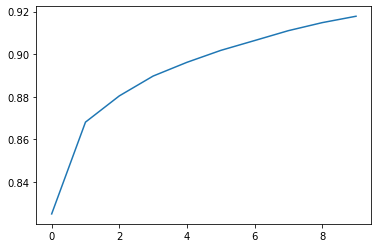

In [155]:
plt.plot(machine.history)

## Conclusion

